In [1]:
!pip install circuitsvis python-dotenv --no-deps

  Using cached circuitsvis-1.43.2-py3-none-any.whl.metadata (2.3 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
Using cached circuitsvis-1.43.2-py3-none-any.whl (1.8 MB)
Using cached python_dotenv-1.0.1-py3-none-any.whl (19 kB)


In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, BitsAndBytesConfig
from peft import PeftModel
import einops
from nnsight import NNsight
from nnsight.models.LanguageModel import LanguageModel
import torch
import pandas as pd
import os
from transformer_lens import HookedTransformer
import numpy as np
from tqdm.notebook import tqdm, trange
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import torch.nn as nn
import circuitsvis as cv
from torch.utils.data import DataLoader, TensorDataset
from collections import defaultdict
import lightning.pytorch as pl
from nnsight import NNsight

from analysis.circuit_utils.visualisation import *
from analysis.circuit_utils.model import *
from analysis.circuit_utils.validation import *
from analysis.circuit_utils.decoding import *
from analysis.circuit_utils.utils import *

from main import load_model_and_tokenizer


device = "cuda:0"


base_args = [
    "--context-weight-format", "float", 
    "--prior-info-flow",
    "--finetuned",
    "--n-samples",  "100",
    "--output-dir", "overnight_results", 
    "--source-heads", "o", "q",
    "--topk", "-1",
    "--batch-size", "32",
]
parser = get_default_parser()
parser.add_argument("--dataset-index", default=0, type=int)
parser.add_argument("--n-samples", default=-1, type=int)
parser.add_argument("--output-dir", default="patching_results")
parser.add_argument("--name", default="")
parser.add_argument("--context-info-flow", action="store_true")
parser.add_argument("--prior-info-flow", action="store_true")
parser.add_argument("--context-to-prior", action="store_true")
parser.add_argument("--prior-to-context", action="store_true")
parser.add_argument("--topk", default=10, type=int)
parser.add_argument("--new-few-shots", default=None, type=int)
parser.add_argument("--zero", action="store_true")
parser.add_argument("--no-filtering", action="store_true")
parser.add_argument("--batch-size", default=-1, type=int)
parser.add_argument("--force-model-confidence", action="store_true")
parser.add_argument("--heads", default=["o"], nargs="+")
parser.add_argument("--source-heads", default=["o", "q"], nargs="+")
parser.add_argument("--layer-range", "-LR", default=[0, -1], nargs=2, type=int)
parser.add_argument("--layers", default=None, nargs="+", type=int)

_StoreAction(option_strings=['--layers'], dest='layers', nargs='+', const=None, default=None, type=<class 'int'>, choices=None, required=False, help=None, metavar=None)

In [2]:
args = parser.parse_args(base_args)
PATHS = paths_from_args(args)
PATHS

{'BASE_MODEL': '/dlabscratch1/public/llm_weights/llama3.1_hf/Meta-Llama-3.1-8B-Instruct',
 'MODEL_NAME': 'Meta-Llama-3.1-8B-Instruct-bs8-ga2-NT-cwf_float',
 'DATAROOT': '/mnt/dlabscratch1/jminder/repositories/context-vs-prior-finetuning/data/BaseFakepedia',
 'TRAIN_DATA': '/mnt/dlabscratch1/jminder/repositories/context-vs-prior-finetuning/data/BaseFakepedia/splits/nodup_relpid/train.csv',
 'DATASET_CONFIG_NAME': 'BaseFakepedia_nodup_relpid-ts2048',
 'PEFT_MODEL': '/mnt/dlabscratch1/jminder/repositories/context-vs-prior-finetuning/data/BaseFakepedia/BaseFakepedia_nodup_relpid-ts2048/3/models/Meta-Llama-3.1-8B-Instruct-bs8-ga2-NT-cwf_float/model',
 'MERGED_MODEL': '/mnt/dlabscratch1/jminder/repositories/context-vs-prior-finetuning/data/BaseFakepedia/BaseFakepedia_nodup_relpid-ts2048/3/models/Meta-Llama-3.1-8B-Instruct-bs8-ga2-NT-cwf_float/merged',
 'VAL_DATA_ALL': '/mnt/dlabscratch1/jminder/repositories/context-vs-prior-finetuning/data/BaseFakepedia/splits/nodup_relpid/val.csv',
 'TRAIN_

In [16]:
model, tokenizer = load_model_and_tokenizer_from_args(PATHS, args)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded model on device cuda:0 with dtype torch.bfloat16.


In [24]:
nnmodel = NNsight(model)

In [17]:
clean_prompt, corrupted_prompt, clean_tokens, corrupted_tokens, correct_index, incorrect_index, attention_mask_clean, attention_mask_corrupted = collect_data(args, PATHS, tokenizer, device)

2024-07-27 10:28:27.552 | INFO     | analysis.circuit_utils.utils:collect_data:111 - Filtered 98 samples
2024-07-27 10:28:27.557 | WARNING  | analysis.circuit_utils.utils:collect_data:162 - Only 24 samples available, reducing n_samples to this value


In [192]:
def get_patched_residuals(nnmodel, site, source_tokens, target_tokens, source_attention_mask, target_attention_mask, scan=False, validate=False):
    residuals = [[] for _ in range(len(nnmodel.model.layers))]
    
    # Clean run
    with nnmodel.trace(clean_tokens, attention_mask=source_attention_mask, scan=scan, validate=validate) as invoker:
        site.cache(nnmodel)
                
    with nnmodel.trace(target_tokens, attention_mask=target_attention_mask, scan=scan, validate=validate) as invoker:
        site.patch(nnmodel)
        for i in range(len(nnmodel.model.layers)):
            residuals[i].append(nnmodel.model.layers[i].output[0][:,-1,:].save())
            
    for i in range(len(nnmodel.model.layers)):
        residuals[i][-1] = residuals[i][-1].value.detach().cpu()
            
    residuals = torch.stack([torch.cat([r.detach() for r in res]) for res in residuals])
    torch.cuda.empty_cache()
    return residuals

def batch_patched_residuals(nnmodel, site, source_tokens, target_tokens, source_attention_mask, target_attention_mask, batch_size=32, scan=False, validate=False):
    residuals = []
    for i in range(0, source_tokens.shape[0], batch_size):
        residuals.append(get_patched_residuals(nnmodel, site, source_tokens[i:i+batch_size], target_tokens[i:i+batch_size], source_attention_mask[i:i+batch_size], target_attention_mask[i:i+batch_size], scan=scan, validate=validate))
    return torch.cat(residuals)

In [221]:
LAYERS = [15, 16, 17]
HEADS = range(32)
site = MultiSite([Site.get_site(Llama3, "o", l, head=h, seq_pos=torch.tensor([-1])) for h in HEADS for l in LAYERS])
residuals = batch_patched_residuals(nnmodel, site, clean_tokens, corrupted_tokens, attention_mask_clean, attention_mask_corrupted, batch_size=32, scan=False, validate=False)

In [222]:
logits = patch_scope(nnmodel, tokenizer, residuals)

I'm thinking about the word ?


100%|██████████| 32/32 [00:01<00:00, 26.08it/s]


In [223]:
aggregation = "mean"
a_rank = get_ranks(logits, correct_index, aggregation)
b_rank = get_ranks(logits, incorrect_index, aggregation)
a_prob = get_probs(logits, correct_index, aggregation)
b_prob = get_probs(logits, incorrect_index, aggregation)

probs = torch.cat([a_prob, b_prob], dim=1)
ranks = torch.cat([a_rank, b_rank], dim=1)

In [224]:
tokenizer.decode(correct_index[0]), tokenizer.decode(incorrect_index[0])

('Apple', 'Argentina')

In [225]:
LAYERS

[15, 16, 17]

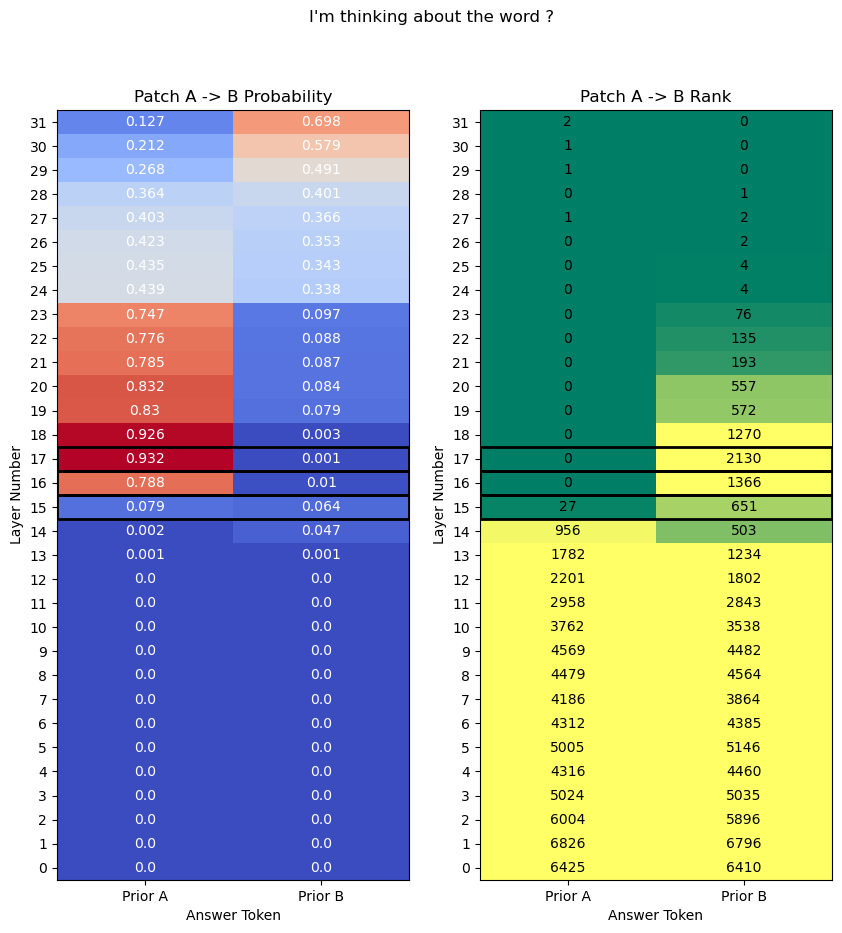

In [226]:
import numpy as np
import matplotlib.pyplot as plt

#  Creating two heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

vmin = min(probs.min(), probs.min())
vmax = max(probs.max(), probs.max())

# Probability heatmap
heatmap = ax1.imshow(probs, cmap='coolwarm', aspect='auto')
# Annotating each cell with the decoded token
for i in range(probs.shape[0]):
    for j in range(probs.shape[1]):
        text = ax1.text(j, i, round(probs[i, j].item(), 3), ha="center", va="center", color="w")

ax1.invert_yaxis()

# Rank heatmap
heatmap = ax2.imshow(ranks, cmap='summer', aspect='auto', vmax=1000)
# Annotating each cell with the decoded token
for i in range(ranks.shape[0]):
    for j in range(ranks.shape[1]):
        text = ax2.text(j, i, int(ranks[i, j].item()), ha="center", va="center", color="black")
        
ax2.invert_yaxis()

# add red square around the patched cells
for l in LAYERS:
    ax1.add_patch(plt.Rectangle((-0.5, l-0.5), 2, 1, fill=False, edgecolor='black', lw=2)) 
    ax2.add_patch(plt.Rectangle((-0.5, l-0.5), 2, 1, fill=False, edgecolor='black', lw=2)) 
# Adding a colorbar
N_LAYERS=32
# Setting axis labels
ax1.set_yticks(range(N_LAYERS), range(0, N_LAYERS))
ax1.set_xticks(range(2), ["Prior A", "Prior B"])
ax1.set_xlabel("Answer Token")
ax1.set_ylabel("Layer Number")
ax1.set_title("Patch A -> B Probability")

ax2.set_yticks(range(N_LAYERS), range(0, N_LAYERS))
ax2.set_xticks(range(2), ["Prior A", "Prior B"])
ax2.set_xlabel("Answer Token")
ax2.set_ylabel("Layer Number")
ax2.set_title("Patch A -> B Rank")

#global title
# plt.suptitle(f"{aggregation.title()} Patch Scope Answer Probability Across Layers of Llama-3-8B-Instruct {'FewShot' if not args.finetuned else 'FineTuned'} Model (CWF={args.context_weight_format})")
plt.suptitle("I'm thinking about the word ?")

plt.show()

In [229]:
probs[24]

tensor([0.4385, 0.3381])

# HeadWise

In [256]:
BASE_LAYERS = [15, 16, 17]
HEADS = range(32)
base_sites = [Site.get_site(Llama3, "o", l, head=h, seq_pos=torch.tensor([-1])) for h in HEADS for l in BASE_LAYERS]
out_ranks, out_probs = [], []
combs = []
# loop through tripples
from itertools import combinations
for (a,b) in combinations(range(32), 2):
    if len(set([a,b])) != 2:
        continue
    combs.append((a,b))
    site = MultiSite(base_sites + [Site.get_site(Llama3, "o", 24, head=a, seq_pos=torch.tensor([-1])), Site.get_site(Llama3, "o", 24, head=b, seq_pos=torch.tensor([-1]))])
    residuals = batch_patched_residuals(nnmodel, site, clean_tokens, corrupted_tokens, attention_mask_clean, attention_mask_corrupted, batch_size=32, scan=False, validate=False)
    logits = patch_scope(nnmodel, tokenizer, residuals)
    aggregation = "mean"
    a_rank = get_ranks(logits, correct_index, aggregation)
    b_rank = get_ranks(logits, incorrect_index, aggregation)
    a_prob = get_probs(logits, correct_index, aggregation)
    b_prob = get_probs(logits, incorrect_index, aggregation)

    probs = torch.cat([a_prob, b_prob], dim=1)
    ranks = torch.cat([a_rank, b_rank], dim=1)
    out_ranks.append(ranks), out_probs.append(probs)

100%|██████████| 32/32 [00:01<00:00, 27.48it/s]


In [270]:
probs = torch.stack(out_probs)[:,24]
ranks = torch.stack(out_ranks)[:,24]
# probs = out_probs[0]
# ranks = out_probs[0]
# probs.shape, ranks.shape

sorted_idx = torch.argsort(probs[:,1], descending=True)
probs = probs[sorted_idx][:50]
ranks = ranks[sorted_idx][:50]
combs_sorted = [combs[i] for i in sorted_idx][:50]

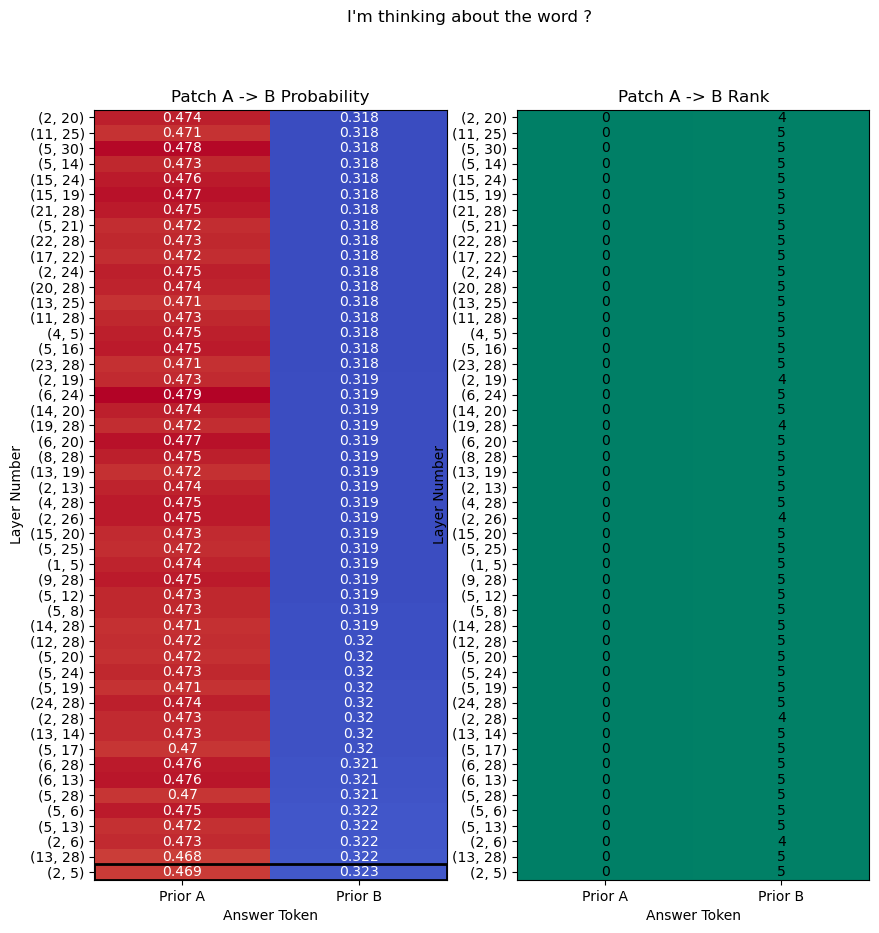

In [271]:
import numpy as np
import matplotlib.pyplot as plt

#  Creating two heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

vmin = min(probs.min(), probs.min())
vmax = max(probs.max(), probs.max())

# Probability heatmap
heatmap = ax1.imshow(probs, cmap='coolwarm', aspect='auto')
# Annotating each cell with the decoded token
for i in range(probs.shape[0]):
    for j in range(probs.shape[1]):
        text = ax1.text(j, i, round(probs[i, j].item(), 3), ha="center", va="center", color="w")

ax1.invert_yaxis()

# Rank heatmap
heatmap = ax2.imshow(ranks, cmap='summer', aspect='auto', vmax=1000)
# Annotating each cell with the decoded token
for i in range(ranks.shape[0]):
    for j in range(ranks.shape[1]):
        text = ax2.text(j, i, int(ranks[i, j].item()), ha="center", va="center", color="black")
        
ax2.invert_yaxis()

max_b = torch.argmax(probs[:,1])

ax1.add_patch(plt.Rectangle((-0.5, max_b-0.5), 2, 1, fill=False, edgecolor='black', lw=2)) 
# Adding a colorbar
N_LAYERS=len(combs_sorted)
# Setting axis labels
ax1.set_yticks(range(N_LAYERS), combs_sorted)
ax1.set_xticks(range(2), ["Prior A", "Prior B"])
ax1.set_xlabel("Answer Token")
ax1.set_ylabel("Layer Number")
ax1.set_title("Patch A -> B Probability")

ax2.set_yticks(range(N_LAYERS), combs_sorted)
ax2.set_xticks(range(2), ["Prior A", "Prior B"])
ax2.set_xlabel("Answer Token")
ax2.set_ylabel("Layer Number")
ax2.set_title("Patch A -> B Rank")

#global title
# plt.suptitle(f"{aggregation.title()} Patch Scope Answer Probability Across Layers of Llama-3-8B-Instruct {'FewShot' if not args.finetuned else 'FineTuned'} Model (CWF={args.context_weight_format})")
plt.suptitle("I'm thinking about the word ?")

plt.show()

In [13]:
prior_rank = torch.cat([prior_prior_rank, prior_context_rank], dim=1)
context_rank = torch.cat([context_prior_rank, context_context_rank], dim=1)
prior_rank.shape, context_rank.shape

(torch.Size([32, 2]), torch.Size([32, 2]))

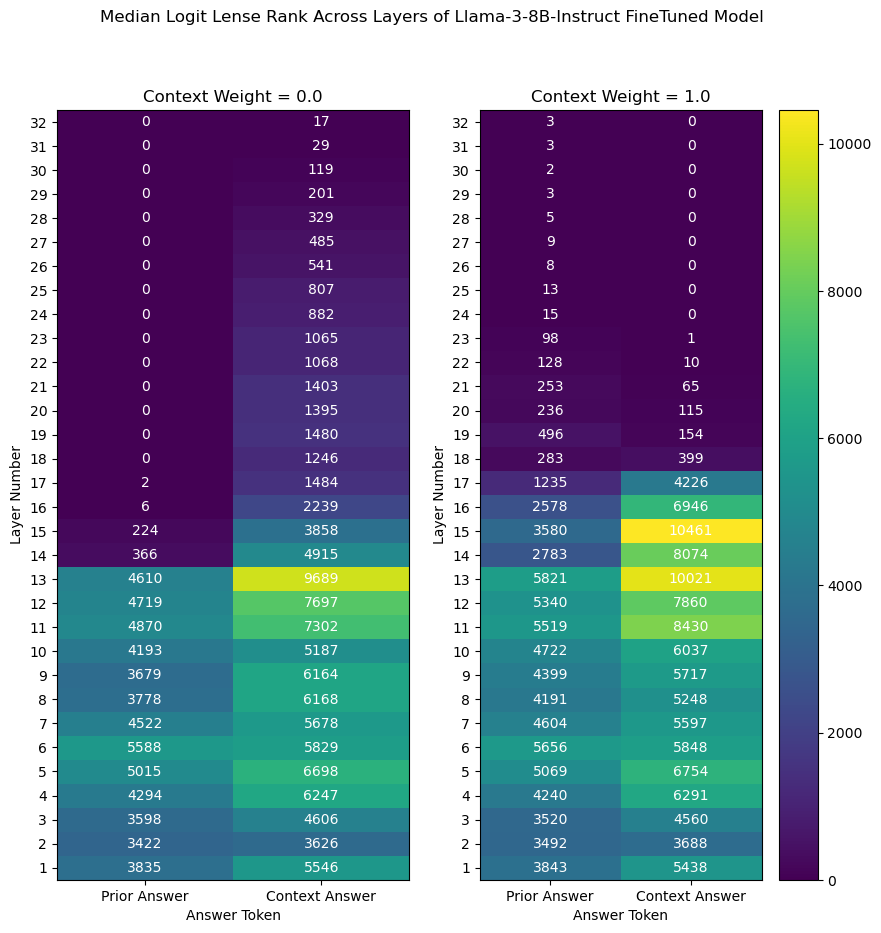

In [85]:
import numpy as np
import matplotlib.pyplot as plt

#  Creating two heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

vmin = min(prior_rank.min(), context_rank.min())
vmax = max(prior_rank.max(), context_rank.max())

# PRIOR
heatmap = ax1.imshow(prior_rank, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
# Annotating each cell with the decoded token
for i in range(prior_rank.shape[0]):
    for j in range(prior_rank.shape[1]):
        text = ax1.text(j, i, int(prior_rank[i, j].item()), ha="center", va="center", color="w")

ax1.invert_yaxis()


# CONTEXT
heatmap = ax2.imshow(context_rank, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
plt.colorbar(heatmap)

for i in range(context_rank.shape[0]):
    for j in range(context_rank.shape[1]):
        text = ax2.text(j, i, int(context_rank[i, j].item()), ha="center", va="center", color="w")
        
ax2.invert_yaxis()
# Adding a colorbar
LAYERS=32
# Setting axis labels
ax1.set_yticks(range(LAYERS), range(1, LAYERS + 1))
ax1.set_xticks(range(2), ["Prior Answer", "Context Answer"])
ax1.set_xlabel("Answer Token")
ax1.set_ylabel("Layer Number")
ax1.set_title("Context Weight = 0.0")

ax2.set_yticks(range(LAYERS), range(1, LAYERS + 1))
ax2.set_xticks(range(2), ["Prior Answer", "Context Answer"])
ax2.set_xlabel("Answer Token")
ax2.set_ylabel("Layer Number")
ax2.set_title("Context Weight = 1.0")

#global title
plt.suptitle(f"{aggregation.title()} Logit Lense Rank Across Layers of Llama-3-8B-Instruct {'FewShot' if not finetuned else 'FineTuned'} Model")


plt.show()

# Patch Scope

In [11]:
prior_residuals.shape

torch.Size([32, 50, 4096])

In [12]:
id_prompt_target = "cat -> cat\n1135 -> 1135\nhello -> hello\n?"
id_prompt_tokens = tokenizer(id_prompt_target, return_tensors="pt", padding=True)["input_ids"].to(device)

In [13]:
prior_logits = []
for i in trange(len(nnmodel.model.layers)):
    with nnmodel.trace(id_prompt_tokens.repeat(prior_residuals.shape[1], 1), validate=False, scan=False):
        nnmodel.model.layers[i].output[0][:,-1,:] = prior_residuals[i, :, :]
        logits = nnmodel.lm_head.output[:, -1, :].save()
    prior_logits.append(logits.value.detach().cpu())
    
prior_logits = torch.stack(prior_logits)

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:02<00:00, 11.15it/s]


In [14]:
context_logits = []
for i in trange(len(nnmodel.model.layers)):
    with nnmodel.trace(id_prompt_tokens.repeat(context_residuals.shape[1], 1), validate=False, scan=False):
        nnmodel.model.layers[i].output[0][:,-1,:] = context_residuals[i, :, :]
        logits = nnmodel.lm_head.output[:, -1, :].save()
    context_logits.append(logits.value.detach().cpu())
    
context_logits = torch.stack(context_logits)

100%|██████████| 32/32 [00:02<00:00, 12.07it/s]


In [15]:
prior_logits.shape, context_logits.shape

(torch.Size([32, 50, 128256]), torch.Size([32, 50, 128256]))

In [16]:
aggregation = "median"
prior_prior_rank = get_ranks(prior_logits, prior_index, aggregation)
prior_context_rank = get_ranks(prior_logits, context_index, aggregation)
context_context_rank = get_ranks(context_logits, context_index, aggregation)
context_prior_rank = get_ranks(context_logits, prior_index, aggregation)

In [17]:
prior_rank = torch.cat([prior_prior_rank, prior_context_rank], dim=1)
context_rank = torch.cat([context_prior_rank, context_context_rank], dim=1)
prior_rank.shape, context_rank.shape

(torch.Size([32, 2]), torch.Size([32, 2]))

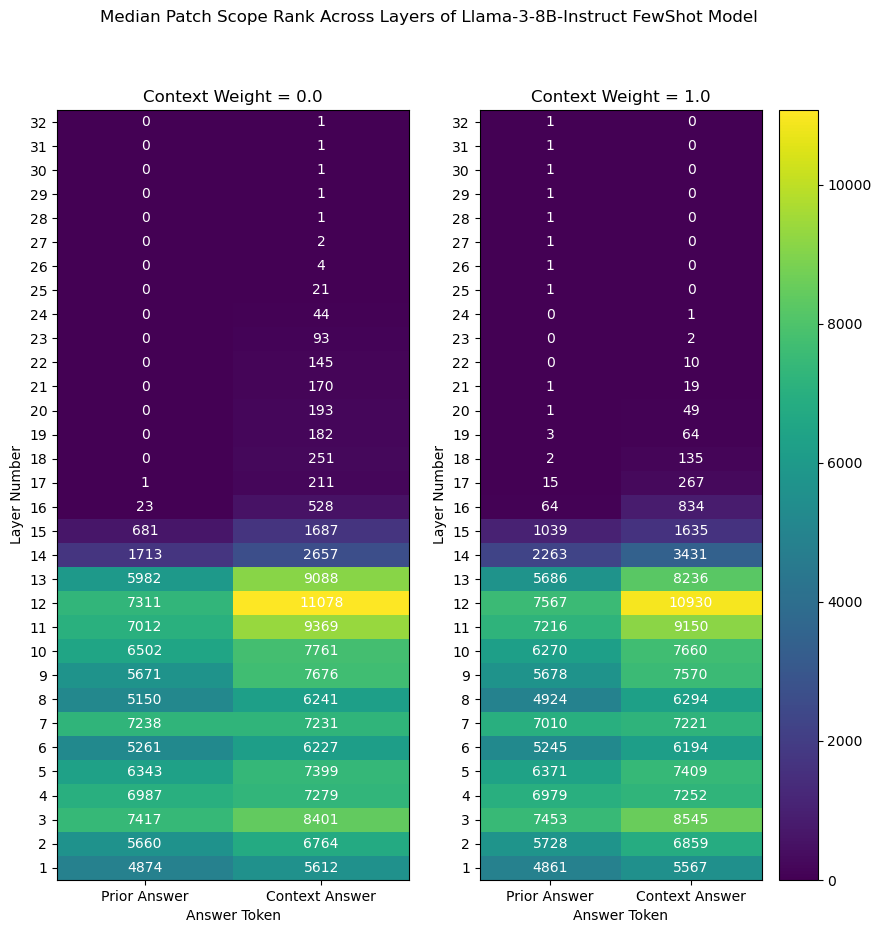

In [18]:
import numpy as np
import matplotlib.pyplot as plt

#  Creating two heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

vmin = min(prior_rank.min(), context_rank.min())
vmax = max(prior_rank.max(), context_rank.max())

# PRIOR
heatmap = ax1.imshow(prior_rank, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
# Annotating each cell with the decoded token
for i in range(prior_rank.shape[0]):
    for j in range(prior_rank.shape[1]):
        text = ax1.text(j, i, int(prior_rank[i, j].item()), ha="center", va="center", color="w")

ax1.invert_yaxis()


# CONTEXT
heatmap = ax2.imshow(context_rank, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
plt.colorbar(heatmap)

for i in range(context_rank.shape[0]):
    for j in range(context_rank.shape[1]):
        text = ax2.text(j, i, int(context_rank[i, j].item()), ha="center", va="center", color="w")
        
ax2.invert_yaxis()
# Adding a colorbar
LAYERS=32
# Setting axis labels
ax1.set_yticks(range(LAYERS), range(1, LAYERS + 1))
ax1.set_xticks(range(2), ["Prior Answer", "Context Answer"])
ax1.set_xlabel("Answer Token")
ax1.set_ylabel("Layer Number")
ax1.set_title("Context Weight = 0.0")

ax2.set_yticks(range(LAYERS), range(1, LAYERS + 1))
ax2.set_xticks(range(2), ["Prior Answer", "Context Answer"])
ax2.set_xlabel("Answer Token")
ax2.set_ylabel("Layer Number")
ax2.set_title("Context Weight = 1.0")

#global title
plt.suptitle(f"{aggregation.title()} Patch Scope Rank Across Layers of Llama-3-8B-Instruct {'FewShot' if not finetuned else 'FineTuned'} Model {'(String Instr)' if not CONTEXT_WEIGHT_AS_INT else ''}")


plt.show()

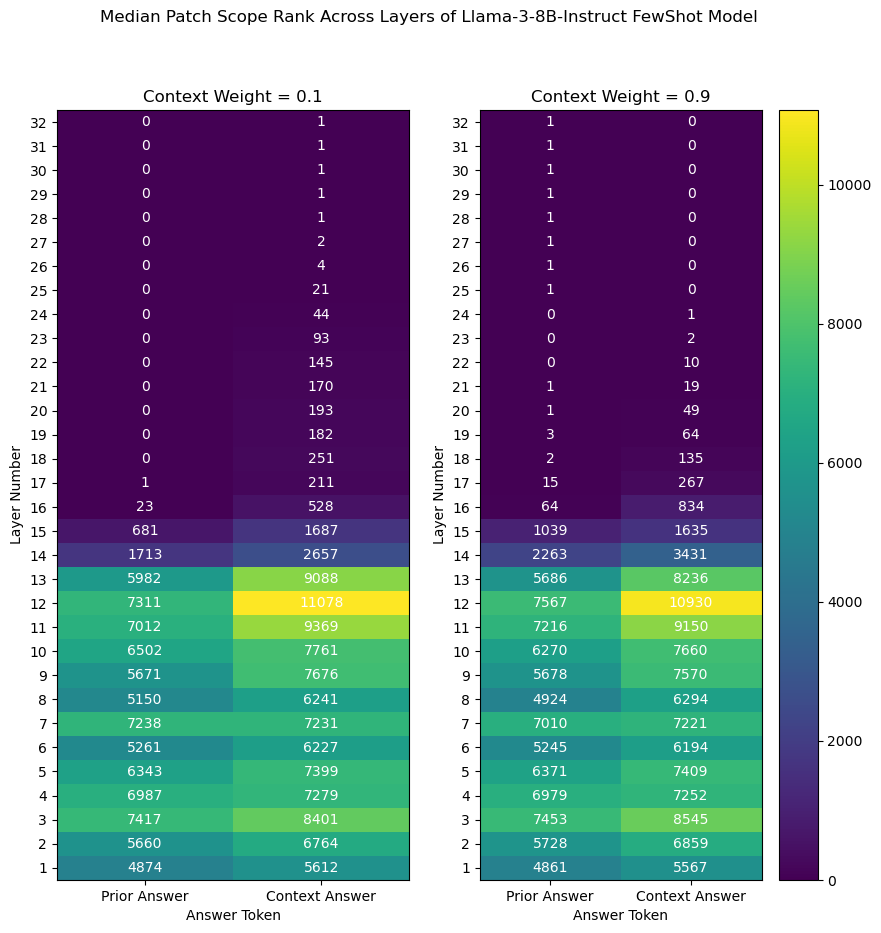

In [19]:
import numpy as np
import matplotlib.pyplot as plt

#  Creating two heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

vmin = min(prior_rank.min(), context_rank.min())
vmax = max(prior_rank.max(), context_rank.max())

# PRIOR
heatmap = ax1.imshow(prior_rank, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
# Annotating each cell with the decoded token
for i in range(prior_rank.shape[0]):
    for j in range(prior_rank.shape[1]):
        text = ax1.text(j, i, int(prior_rank[i, j].item()), ha="center", va="center", color="w")

ax1.invert_yaxis()


# CONTEXT
heatmap = ax2.imshow(context_rank, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
plt.colorbar(heatmap)

for i in range(context_rank.shape[0]):
    for j in range(context_rank.shape[1]):
        text = ax2.text(j, i, int(context_rank[i, j].item()), ha="center", va="center", color="w")
        
ax2.invert_yaxis()
# Adding a colorbar
LAYERS=32
# Setting axis labels
ax1.set_yticks(range(LAYERS), range(1, LAYERS + 1))
ax1.set_xticks(range(2), ["Prior Answer", "Context Answer"])
ax1.set_xlabel("Answer Token")
ax1.set_ylabel("Layer Number")
ax1.set_title("Context Weight = 0.1")

ax2.set_yticks(range(LAYERS), range(1, LAYERS + 1))
ax2.set_xticks(range(2), ["Prior Answer", "Context Answer"])
ax2.set_xlabel("Answer Token")
ax2.set_ylabel("Layer Number")
ax2.set_title("Context Weight = 0.9")

#global title
plt.suptitle(f"{aggregation.title()} Patch Scope Rank Across Layers of Llama-3-8B-Instruct {'FewShot' if not finetuned else 'FineTuned'} Model {'(String Instr)' if not CONTEXT_WEIGHT_AS_INT else ''}")


plt.show()

In [21]:
aggregation = "median"
prior_prior_prob = get_probs(prior_logits, prior_index, aggregation)
prior_context_prob = get_probs(prior_logits, context_index, aggregation)
context_context_prob = get_probs(context_logits, context_index, aggregation)
context_prior_prob = get_probs(context_logits, prior_index, aggregation)

In [22]:
prior_prob = torch.cat([prior_prior_prob, prior_context_prob], dim=1)
context_prob = torch.cat([context_prior_prob, context_context_prob], dim=1)

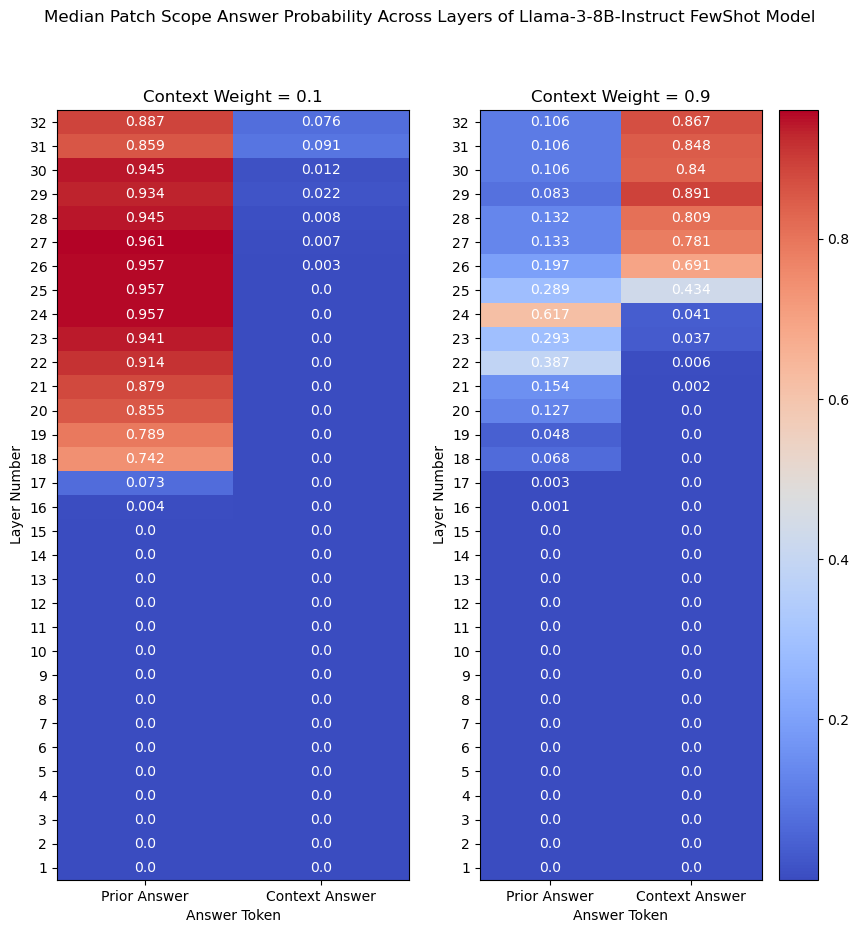

In [23]:
import numpy as np
import matplotlib.pyplot as plt

#  Creating two heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

vmin = min(prior_prob.min(), context_prob.min())
vmax = max(prior_prob.max(), context_prob.max())

# PRIOR
heatmap = ax1.imshow(prior_prob, cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
# Annotating each cell with the decoded token
for i in range(prior_prob.shape[0]):
    for j in range(prior_prob.shape[1]):
        text = ax1.text(j, i, round(prior_prob[i, j].item(), 3), ha="center", va="center", color="w")

ax1.invert_yaxis()


# CONTEXT
heatmap = ax2.imshow(context_prob, cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
plt.colorbar(heatmap)

for i in range(context_prob.shape[0]):
    for j in range(context_prob.shape[1]):
        text = ax2.text(j, i, round(context_prob[i, j].item(), 3), ha="center", va="center", color="w")
        
ax2.invert_yaxis()
# Adding a colorbar
LAYERS=32
# Setting axis labels
ax1.set_yticks(range(LAYERS), range(1, LAYERS + 1))
ax1.set_xticks(range(2), ["Prior Answer", "Context Answer"])
ax1.set_xlabel("Answer Token")
ax1.set_ylabel("Layer Number")
ax1.set_title("Context Weight = 0.1")

ax2.set_yticks(range(LAYERS), range(1, LAYERS + 1))
ax2.set_xticks(range(2), ["Prior Answer", "Context Answer"])
ax2.set_xlabel("Answer Token")
ax2.set_ylabel("Layer Number")
ax2.set_title("Context Weight = 0.9")

#global title
plt.suptitle(f"{aggregation.title()} Patch Scope Answer Probability Across Layers of Llama-3-8B-Instruct {'FewShot' if not finetuned else 'FineTuned'} Model {'(String Instr)' if not CONTEXT_WEIGHT_AS_INT else ''}")


plt.show()

In [ ]:
clean_tokens[0]

tensor([128000, 128006,   9125,  ..., 128001, 128001, 128001], device='cuda:0')